## Imports & Setup

In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Compose, Resize, RandomHorizontalFlip, RandomAdjustSharpness, Grayscale, Normalize
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
from helpers import *
from architecture.CNN import *
from architecture.AutoEncoder import *

In [2]:
torch.manual_seed(27)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Prepare Dataset

In [5]:
def create_subsets(root, transformation):
    dataset = ImageFolder(root, transformation)
    train, test, val = torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1])
    return train, test, val

In [6]:
def produce_loaders(train, test, val):
    train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True)
    test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)
    valid_loader = torch.utils.data.DataLoader(val, batch_size = batch_size, shuffle = False)
    return train_loader, test_loader, valid_loader

In [4]:
size = 44
batch_size = 128
transformation = Compose([RandomHorizontalFlip(), Resize((size, size)), ToTensor()])

In [7]:
root = 'expanded_dataset/cropped_aug'
train_data, test_data, val_data = create_subsets(root, transformation)
train_loader, test_loader, val_loader = produce_loaders(train_data, test_data, val_data)

[6685, 3537, 385, 4353, 7114, 641, 519, 7223, 4512]


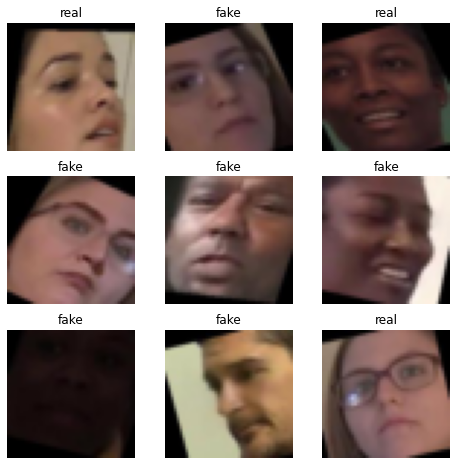

In [8]:
visualize_data(train_data)

[437, 912, 568, 151, 721, 255, 313, 623, 724]


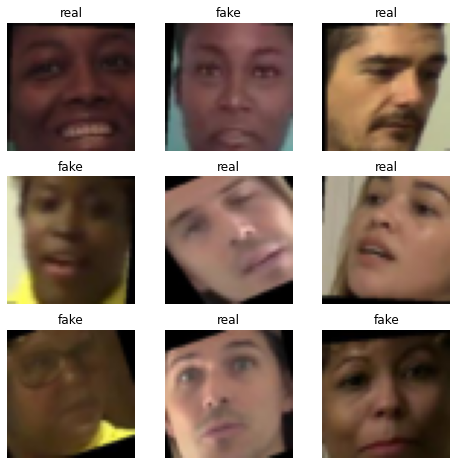

In [9]:
visualize_data(test_data)

## Load AutoEncoder

In [12]:
# number of hidden layers and their sizes
hidden_a = [3, 32, 64, 128, 256]

# kernel size of convolution layers
kernel_size_a = 3

In [13]:
autoencmodel = AutoEncoder(hidden_a, kernel_size_a).to(device)
autoencmodel.load_state_dict(torch.load("./autoencoder256_22epochs")["model_state_dict"])

<All keys matched successfully>

In [14]:
# freeze autoencoder parameters
for param in autoencmodel.parameters():
    param.requiresGrad = False
print(autoencmodel)

AutoEncoder(
  (enc_combined): Sequential(
    (0): Encoder(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
      (batchnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.01)
    )
    (1): Encoder(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.01)
    )
    (2): Encoder(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.01)
    )
    (3): Encoder(
      (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
      (batchnorm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.01)
    )
  )
  (dec_combined): Seq

## Initialise Model

In [15]:
def create_adam_optimizer(model, lr = 0.1, betas=(0.9, 0.999), amsgrad=False, weight_decay=1e-5):
    return optim.Adam(model.parameters(), lr = lr, amsgrad=amsgrad, betas=betas)

In [16]:
from math import floor
# kernel size of convolution layers
kernel_size = 3

# number of hidden layers and their sizes
hidden = [256, 256, 128, 64]

# window size of maxpooling layer
window = 2

# calculate final size of image
new_size = size-(kernel_size_a-1)*(len(hidden_a)-1)
channels = hidden[-1]
changed_img = floor( (new_size-(kernel_size-1)*(len(hidden)-1)) / window )

# calculate dimension of flattened image
flattened = channels*changed_img*changed_img

# final linear layers and their sizes
hidden_linear = [flattened, 512, 64]

In [19]:
model = DeepSearch(hidden=hidden, kernel_size=kernel_size,
                  window=window, hidden_linear=hidden_linear).to(device)
print(model)

DeepSearch(
  (conv_combined): Sequential(
    (0): DeepSearchConv(
      (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
      (batch_norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout2d(p=0.5, inplace=False)
    )
    (1): DeepSearchConv(
      (conv): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1))
      (batch_norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout2d(p=0.5, inplace=False)
    )
    (2): DeepSearchConv(
      (conv): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
      (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout2d(p=0.5, inplace=False)
    )
  )
  (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (linear_combined): Sequential(
    (0): DeepSearchLinear(
      (linear): Linear(in_features=14400, out_features=512, bias=True)
      (batch_norm): Batc

## Training Model

In [20]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [21]:
optimizer = create_adam_optimizer(model, lr=0.001)

In [32]:
"""
train

Function used to train the model. Returns four lists for the purposes of plotting performance curves.

Parameters:
device - device to use
model - model to train
train_loader - training data loader
val_loader - validation data loader
optimizer - optimizer to use (allows for saving and reloading optimizer state to stop and resume training)
epochs - epochs to train the model
criterion - loss function to use (default is cross entropy)
patience - number of iterations validation loss is allowed to increase before training is stopped (default is 3)
autoencoder - autoencoder to use, if any (default is None)
checkpoint - if True, a checkpoint of the model (and optimizer) will saved if the model either has the current
             lowest validation loss, has a validation accuracy of at least 90%, or both (default is True)

Returns lists of the training loss, training accuracy, validation loss and validation accuracy for plotting curves.

"""
tl, ta, vl, va = train(device=device, model=model,
                       train_loader=train_loader, val_loader=val_loader, 
                       optimizer=optimizer, epochs=20, autoencoder=autoencmodel)
train_losses+=tl
train_accuracies+=ta
val_losses+=vl
val_accuracies+=va

Epoch 1/20, Batch number: 0, Cumulated accuracy: 0.875
Epoch 1/20, Batch number: 5, Cumulated accuracy: 0.8489583333333334
Epoch 1/20, Batch number: 10, Cumulated accuracy: 0.8579545454545454
Epoch 1/20, Batch number: 15, Cumulated accuracy: 0.86865234375
Epoch 1/20, Batch number: 20, Cumulated accuracy: 0.8649553571428571
Epoch 1/20, Batch number: 25, Cumulated accuracy: 0.8608774038461539
Epoch 1/20, Batch number: 30, Cumulated accuracy: 0.8664314516129032
Epoch 1/20, Batch number: 35, Cumulated accuracy: 0.8678385416666666
Epoch 1/20, Batch number: 40, Cumulated accuracy: 0.8683307926829268
Epoch 1/20, Batch number: 45, Cumulated accuracy: 0.8688858695652174
Epoch 1/20, Batch number: 50, Cumulated accuracy: 0.8702512254901961
Epoch 1/20, Batch number: 55, Cumulated accuracy: 0.8696986607142857
Epoch 1/20, Batch number: 60, Cumulated accuracy: 0.8693647540983607
--- Epoch 1/20: Train loss: 0.3011, Train accuracy: 0.8702
--- Epoch 1/20: Val loss: 0.2468, Val accuracy: 0.9082
Epoch 2/2

## Testing Model & Performance Curves

In [33]:
"""
test

Function used to obtain the validation or test loss and accuracy of the model. Can also return
additional lists used for confusion matrix computation.

Parameters:
device - device to use
model - model to train
data_loader - chosen (testing) data loader
criterion - loss function to use (default is cross entropy)
autoencoder - autoencoder to use, if any (default is None)
get_predictions - if True, returns the list of true labels, the list of predictions made by the model, 
                  followed by values of the test loss and test accuracy (default is False)

By default, returns values of the test loss and test accuracy. Set get_predictions to True (as mentioned above) to
obtain the lists of true labels and list of preidctions made by the model on top of the test loss and accuracy.

"""
true_labels, model_preds, test_loss, test_accuracy = test(device, model, test_loader, autoencoder=autoencmodel, get_predictions=True)

Test loss: 0.1933, Test accuracy: 0.9140


Precision: 0.9421157684630739
Recall: 0.8872180451127819
F1 score: 0.9138431752178122


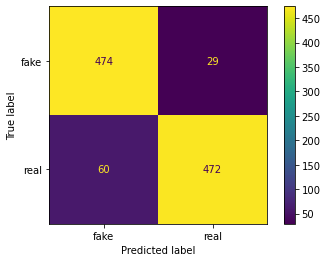

In [34]:
'''
Takes in lists of the true labels and model predictions,
then computes the precision, recall, and f1 score

'''
show_metrics(true_labels, model_preds)

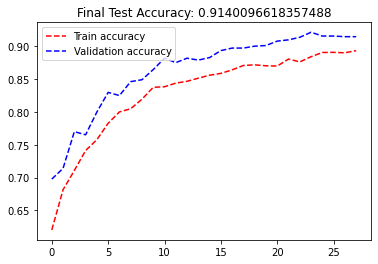

In [35]:
plt.plot(train_accuracies, "r--", label='Train accuracy')
plt.plot(val_accuracies, "b--", label='Validation accuracy')
plt.title("Final Test Accuracy: {}".format(test_accuracy))
plt.legend(loc='upper left')
plt.show()

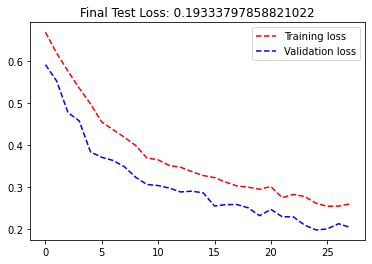

In [36]:
plt.plot(train_losses, "r--", label='Training loss')
plt.plot(val_losses, "b--", label='Validation loss')
plt.title("Final Test Loss: {}".format(test_loss))
plt.legend(loc='upper right')
plt.show()

## Viewing Model Predictions

In [37]:
test_loader2 = produce_loader(test_data, 1)

In [44]:
"""
get_pictures_test

A simplified version of the test function that returns four lists
used for image visualization and confusion matrix computation.

Parameters:
device - device to use
model - model to train
data_loader - chosen (testing) data loader
autoencoder - autoencoder to use, if any (default is None)

Returns a list of correctly predicted images, a list of incorrectly predicted images, a list of true labels,
and a list of predictions made by the model each of length equal to the length of the data loader provided.

"""
correct_list, wrong_list, true_labels2, model_preds2 = get_pictures_test(device, model, test_loader2, autoencoder=autoencmodel)

Precision: 0.6811594202898551
Recall: 0.5300751879699248
F1 score: 0.5961945031712473


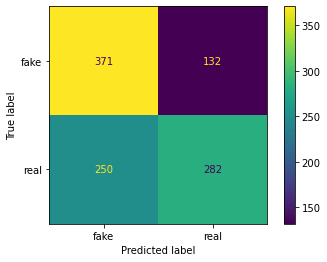

In [45]:
show_metrics(true_labels2, model_preds2)

[176, 317, 6, 352, 265, 624, 443, 383, 429, 560, 265, 528, 262, 93, 225, 343, 563, 345, 199, 603, 367, 440, 486, 160, 344]


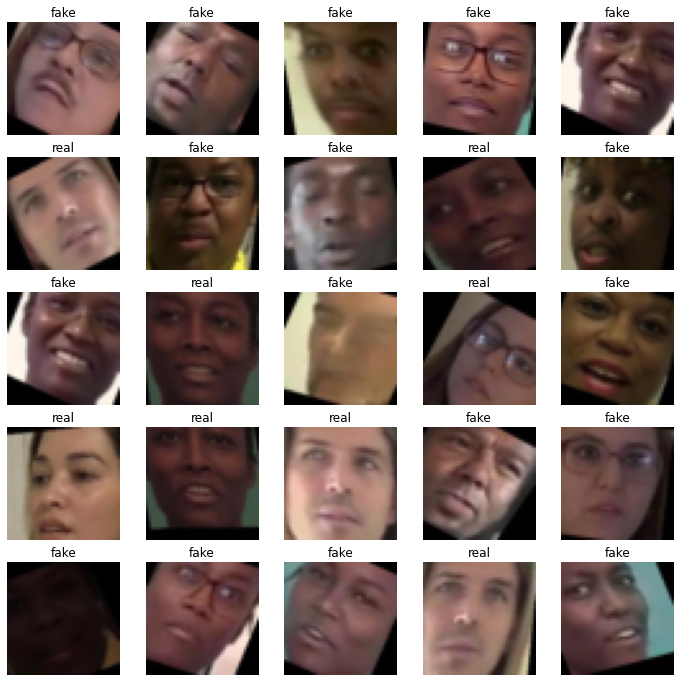

In [40]:
visualize_data(correct_list, (12,12), 5)

[309, 150, 70, 78, 202, 21, 254, 342, 201, 258, 286, 370, 115, 357, 59, 127, 172, 28, 176, 263, 140, 130, 382, 164, 169]


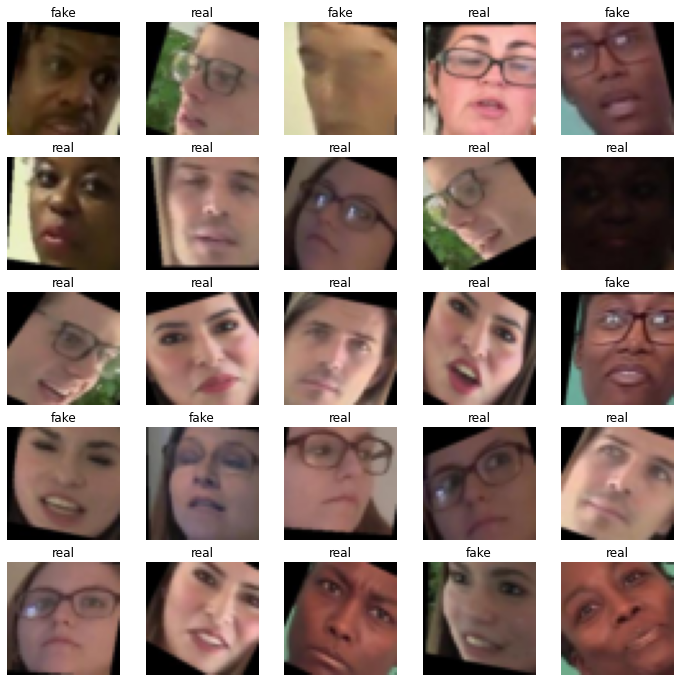

In [41]:
visualize_data(wrong_list, (12,12), 5)

## Saving Model

torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()}, 
            './CNNwithAE_10epochs')

## Hyperparam Tuning

In [49]:
#Hyperparameters
from math import floor

#sharp sobel kernels
kernels3 = [torch.tensor([[0., -1., 0.],
                        [-1., 5., -1.],
                        [0., -1., 0.]]),
           torch.tensor([[1., 2., 1.],
                        [0., 0., 0.],
                        [-1., -2., -1.]]),
           torch.tensor([[1., 0., -1.],
                        [2., 0., -2.],
                        [1., 0., -1.]])]

kernels5=[torch.tensor([[2.,2.,4.,2.,2.],
                      [1.,1.,2.,1.,1.],
                      [0.,0.,0.,0.,0.],
                      [-1.,-1.,-2.,-1.,-1.],
                      [-2.,-2.,-4.,-2.,-2.]]),
         torch.tensor([[2., 1., 0., -1., -2.],
                      [2., 1., 0., -1., -2.],
                      [4., 2., 0., -2., -4.],
                      [2., 1., 0., -1., -2.],
                      [2., 1., 0., -1., -2.]]),
         torch.tensor([[-1/256,-4/256,-6/256,-4/256,-1/256],
                      [-4/256,-16/256,-24/256,-16/256, -4/256],
                      [-6/256, -24/256, 476/256, -24/256, -6/256],
                      [-4/256,-16/256,-24/256,-16/256, -4/256],
                      [-1/256,-4/256,-6/256,-4/256,-1/256]])] #unsharp masking

# number of hidden neurons in Conv layers and their sizes
hidden = [256, 256, 128, 64]
hidden_list=[[256, 256, 128, 64], [256, 512,128,64], [256,512,128]]

# kernel size of convolution layers
kernel_size = 3


# window size of maxpooling layer
window = 2


# calculate final size of image
new_size = size-(kernel_size_a-1)*(len(hidden_a)-1)
channels = hidden[-1]
changed_img = floor( (new_size-(kernel_size-1)*(len(hidden)-1)) / window )

# calculate dimension of flattened image
flattened = channels*changed_img*changed_img

# final linear layers and their sizes
hidden_linear = [flattened, 512, 64]


#learning rate of optimiser
lr=0.01



#hyperparams

weight_decay=1e-5

hidden_list=[[256, 256, 128, 64], [256, 512,128,64], [256,512,128]]

kernel_list=[3,5]

window_list=[2,3,5]

hidden_linear_list=[[flattened, 512, 64],  [flattened,1024, 512], [flattened,1024,512,256]]

lr_list=[0.01,0.005,0.001]

dropout_list=[0.3,0.5,0.7]

In [50]:
test_param="dropout" #edit param name
test_losses = []
test_accuracies = []
precision_list=[]
recall_list=[]
f1_list=[]
epochs=10
 
for dropout in dropout_list: #edit param list and name
    print(test_param+'='+str(dropout)) #edit param name in str
    new_size = size-(kernel_size_a-1)*(len(hidden_a)-1)
    channels = hidden[-1]
    changed_img = floor( (new_size-(kernel_size-1)*(len(hidden)-1)) / window )
    flattened = channels*changed_img*changed_img
    hidden_linear[0]=flattened
    if(kernel_size==3):
        kernels=kernels3
    elif(kernel_size==5):
        kernels=kernels5
    
    model = DeepLearn(kernels=kernels, hidden=hidden, kernel_size=kernel_size,
                  window=window, hidden_linear=hidden_linear, dropout=dropout).to(device)
    
    
   
    optimizer = create_adam_optimizer(model, lr=lr, weight_decay=weight_decay)
    
    tl, ta, vl, va = train(device, model,
                       train_loader, val_loader, 
                       optimizer, epochs = epochs, autoencoder=autoencmodel, checkpoint=False)
    true_labels, model_preds, test_loss, test_accuracy = test(device, model, test_loader, autoencoder=autoencmodel, get_predictions=True)
    p,r,f= return_metrics(true_labels, model_preds)
                           
    test_losses+=[test_loss]
    test_accuracies+=[test_accuracy]
    precision_list+=[p]
    recall_list+=[r]
    f1_list+=[f]


dropout=0.3
Epoch 1/10, Batch number: 0, Cumulated accuracy: 0.6015625
Epoch 1/10, Batch number: 5, Cumulated accuracy: 0.7486979166666666
Epoch 1/10, Batch number: 10, Cumulated accuracy: 0.7791193181818182
Epoch 1/10, Batch number: 15, Cumulated accuracy: 0.7998046875
Epoch 1/10, Batch number: 20, Cumulated accuracy: 0.8180803571428571
Epoch 1/10, Batch number: 25, Cumulated accuracy: 0.8290264423076923
Epoch 1/10, Batch number: 30, Cumulated accuracy: 0.8341733870967742
Epoch 1/10, Batch number: 35, Cumulated accuracy: 0.8448350694444444
Epoch 1/10, Batch number: 40, Cumulated accuracy: 0.8471798780487805
Epoch 1/10, Batch number: 45, Cumulated accuracy: 0.8513926630434783
--- Epoch 1/10: Train loss: 0.3338, Train accuracy: 0.8522
--- Epoch 1/10: Val loss: 0.5429, Val accuracy: 0.7846
Epoch 2/10, Batch number: 0, Cumulated accuracy: 0.953125
Epoch 2/10, Batch number: 5, Cumulated accuracy: 0.8841145833333334
Epoch 2/10, Batch number: 10, Cumulated accuracy: 0.9019886363636364
Epoch 

Epoch 2/10, Batch number: 25, Cumulated accuracy: 0.8990384615384616
Epoch 2/10, Batch number: 30, Cumulated accuracy: 0.8989415322580645
Epoch 2/10, Batch number: 35, Cumulated accuracy: 0.8984375
Epoch 2/10, Batch number: 40, Cumulated accuracy: 0.8999618902439024
Epoch 2/10, Batch number: 45, Cumulated accuracy: 0.8987771739130435
--- Epoch 2/10: Train loss: 0.2631, Train accuracy: 0.8990
--- Epoch 2/10: Val loss: 0.3210, Val accuracy: 0.8615
Epoch 3/10, Batch number: 0, Cumulated accuracy: 0.9140625
Epoch 3/10, Batch number: 5, Cumulated accuracy: 0.90234375
Epoch 3/10, Batch number: 10, Cumulated accuracy: 0.9090909090909091
Epoch 3/10, Batch number: 15, Cumulated accuracy: 0.904296875
Epoch 3/10, Batch number: 20, Cumulated accuracy: 0.9077380952380952
Epoch 3/10, Batch number: 25, Cumulated accuracy: 0.9080528846153846
Epoch 3/10, Batch number: 30, Cumulated accuracy: 0.9077620967741935
Epoch 3/10, Batch number: 35, Cumulated accuracy: 0.912109375
Epoch 3/10, Batch number: 40, C

--- Epoch 3/10: Train loss: 0.2953, Train accuracy: 0.8900
--- Epoch 3/10: Val loss: 0.3397, Val accuracy: 0.8564
Epoch 4/10, Batch number: 0, Cumulated accuracy: 0.921875
Epoch 4/10, Batch number: 5, Cumulated accuracy: 0.890625
Epoch 4/10, Batch number: 10, Cumulated accuracy: 0.8977272727272727
Epoch 4/10, Batch number: 15, Cumulated accuracy: 0.89111328125
Epoch 4/10, Batch number: 20, Cumulated accuracy: 0.8943452380952381
Epoch 4/10, Batch number: 25, Cumulated accuracy: 0.8936298076923077
Epoch 4/10, Batch number: 30, Cumulated accuracy: 0.8931451612903226
Epoch 4/10, Batch number: 35, Cumulated accuracy: 0.8940972222222222
Epoch 4/10, Batch number: 40, Cumulated accuracy: 0.8932926829268293
Epoch 4/10, Batch number: 45, Cumulated accuracy: 0.893172554347826
--- Epoch 4/10: Train loss: 0.2635, Train accuracy: 0.8932
--- Epoch 4/10: Val loss: 0.3236, Val accuracy: 0.8650
Epoch 5/10, Batch number: 0, Cumulated accuracy: 0.890625
Epoch 5/10, Batch number: 5, Cumulated accuracy: 0.9

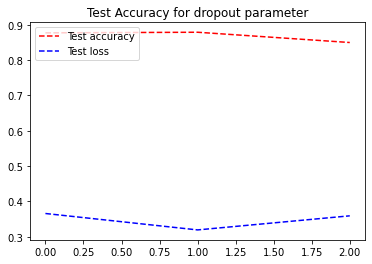

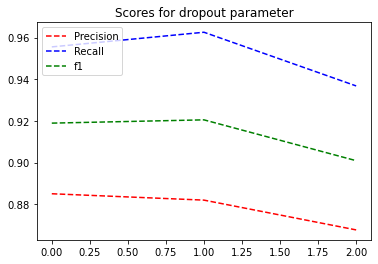

In [51]:
plt.plot(test_accuracies, "r--", label='Test accuracy')
plt.plot(test_losses, "b--", label='Test loss')
plt.title(f'Test Accuracy for {test_param} parameter')
plt.legend(loc='upper left')
plt.show()

plt.plot(precision_list, "r--", label='Precision')
plt.plot(recall_list, "b--", label='Recall')
plt.plot(f1_list, "g--", label='f1')
plt.title(f'Scores for {test_param} parameter')
plt.legend(loc='upper left')
plt.show()

In [52]:
print(f'test accuracy: {test_accuracies}')
print(f'test loss: {test_losses}')
print(f'precision: {precision_list}')
print(f'recall: {recall_list}')
print(f'f1 score: {f1_list}')

test accuracy: [0.8769230769230769, 0.8786324786324786, 0.8495726495726496]
test loss: [0.3658772945404053, 0.3194199949502945, 0.3592743158340454]
precision: [0.8850325379609545, 0.8819742489270386, 0.8676789587852495]
recall: [0.955503512880562, 0.9625292740046838, 0.936768149882904]
f1 score: [0.9189189189189189, 0.9204927211646137, 0.9009009009009009]
